In [1]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data and True Labels

In [26]:
#----------------------------------------------- DATA ------------------------------------------------------------------
data_dir = "data/"

clear_data = np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")
ambig_data = np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy")
#np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy") #np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")

clear_amplitude_conditions = ["S", "M", "L"]  #["S", "S/M", "M", "M/L", "L"] #["S", "M", "L"]
ambig_amplitude_conditions = ["S", "S/M", "M", "M/L", "L"]

clear_time_constant_conditions = ["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]
ambig_time_constant_conditions = ["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]

#["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]
#["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]

ambiguous_conditions = ["S/M", "M/L", "equal_medium", "wide_medium_negative_skew", "medium_sharp_negative_skew", "medium_wide_positive_skew", "sharp_medium_positive_skew"]

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

ambig_cluster_dict = get_index_per_class(ambig_amplitude_conditions,ambig_time_constant_conditions, ambiguous_conditions, samples_per_condition, samples_per_ambiguous_condition)
clear_cluster_dict = get_index_per_class(clear_amplitude_conditions,clear_time_constant_conditions, [], samples_per_condition, samples_per_ambiguous_condition)


clear_true_labels = get_labels(clear_data, clear_cluster_dict)
ambig_true_labels = get_labels(ambig_data, ambig_cluster_dict)

clear_clusters_ordered = list(range(0,len(clear_cluster_dict)+1))
clear_layout_label_mapping = labels_to_layout_mapping(clear_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))

ambig_clusters_ordered = list(range(0,len(ambig_cluster_dict)+1))
ambig_layout_label_mapping = labels_to_layout_mapping(ambig_clusters_ordered, 9, (2,5))

## Cluster Balanced Split

In [27]:
clear_train_fold_indices, _ = training_set_split.get_training_folds(clear_data, clear_cluster_dict,cluster_split="balanced",folds = 2)
ambig_train_fold_indices, _ = training_set_split.get_training_folds(ambig_data, ambig_cluster_dict,cluster_split="balanced",folds = 2)


clear_training_set = clear_data[clear_train_fold_indices[0]]
clear_validation_set = clear_data[clear_train_fold_indices[1]]

ambig_training_set = ambig_data[ambig_train_fold_indices[0]]
ambig_validation_set = ambig_data[ambig_train_fold_indices[1]]

clear_true_labels_training = clear_true_labels[clear_train_fold_indices[0]]
clear_true_labels_validation = clear_true_labels[clear_train_fold_indices[1]]

ambig_true_labels_training = ambig_true_labels[ambig_train_fold_indices[0]]
ambig_true_labels_validation = ambig_true_labels[ambig_train_fold_indices[1]]

## Spectral Clustering Configuration

In [29]:
k = 10
regs = [None, 0.01, 0.1, 1, 10, 100]  
ambig_prediction_strength_dir = "Toy_data/Ambiguous/Ambiguous_Tau_Amplitude/Prediction_Strength/"

In [ ]:
for reg in regs:
    labels_train, eigvec_train, eigval_train = spectral_clustering(ambig_training_set, "euclidean","distance",range(1,50), k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(ambig_prediction_strength_dir + "labels/labels_k=%d_reg=%s_training" % (k, str(reg)),labels_train)
    np.save(ambig_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_training" % (k, str(reg)),eigval_train)
    
    labels_valid, eigvec_valid, eigval_valid = spectral_clustering(ambig_validation_set, "euclidean","distance", range(1,50),  k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(ambig_prediction_strength_dir + "labels/labels_k=%d_reg=%s_validation" % (k, str(reg)),labels_valid)
    np.save(ambig_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_validation" % (k, str(reg)),eigval_valid)
    

Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian


In [9]:
clusters_from_ambig_dataset, counts = np.unique(ambig_true_labels, return_counts = True)
clear_clusters_from_ambig = clusters_from_ambig_dataset[np.where(counts!= 400)]

In [11]:
list(clear_clusters_from_ambig)

[0.0, 2.0, 3.0, 6.0, 18.0, 20.0, 21.0, 24.0, 36.0, 38.0, 39.0, 42.0]

# Graph Analysis

In [9]:
from spectral_clustering import calculate_dist_matrix
from spectral_clustering import construct_knn_graph
from spectral_clustering import get_local_scaled_affinity_matrix

In [7]:
test_data = np.zeros((1200, len(clear_data[0])))
for i,key in enumerate(list(clear_cluster_dict.keys())):
    start = clear_cluster_dict[key][0]
    test_data[i*100:(i+1)*100,:] = clear_data[start:start+100,:]

In [ ]:
dist_matrix, sorted_dist_matrix = calculate_dist_matrix(clear_data, "minkowski")

In [35]:
dist_matrix, sorted_dist_matrix = calculate_dist_matrix(clear_data, "euclidean")

In [9]:
dist_matrix = clear_data@clear_data.T

In [115]:
dist_matrix, sorted_dist_matrix = get_local_scaled_affinity_matrix(clear_data,k=250,metric="euclidean")

In [36]:
#2xy/(x2+y2)

#dist_matrix = np.ones((len(clear_data), len(clear_data)))
#for i in range(len(clear_data)):
#    for j in range(len(clear_data)):
#        if i == j:
#            continue  # self-distance is 1
#        if i > j:
#            dist_matrix[i, j] = dist_matrix[j, i]  # re-use earlier calc
#             
#        dist_matrix[i, j] = 2 * (clear_data[i] @ clear_data[j].T) / (clear_data[i] @ clear_data[i].T + clear_data[j] @ clear_data[j].T)


sim_matrix = clear_data @ clear_data.T 
diag = sim_matrix.diagonal()
denom = diag.reshape((len(diag),1)) + diag
sim_matrix = 2 * sim_matrix / denom

#sim_matrix = np.load("SSIM.npy")

In [29]:
1 - sim_matrix

array([[0.        , 0.0486501 , 0.03543279, ..., 0.97802348, 0.97753978,
        0.97107147],
       [0.0486501 , 0.        , 0.07583126, ..., 0.9697033 , 0.96848633,
        0.96133947],
       [0.03543279, 0.07583126, 0.        , ..., 0.97429414, 0.97392254,
        0.96574524],
       ...,
       [0.97802348, 0.9697033 , 0.97429414, ..., 0.        , 0.00697975,
        0.03717762],
       [0.97753978, 0.96848633, 0.97392254, ..., 0.00697975, 0.        ,
        0.04377593],
       [0.97107147, 0.96133947, 0.96574524, ..., 0.03717762, 0.04377593,
        0.        ]])

In [49]:
weighted_dist_matrix = (1 - sim_matrix) * dist_matrix

In [53]:
print(np.argsort(weighted_dist_matrix)[:,0:10])
print(np.argsort(dist_matrix)[:,0:10])
print(np.argsort(sim_matrix)[:,-10:])

[[    0   340   170 ...   154   420   328]
 [    1   450   672 ...   361   807   719]
 [    2   464   229 ...   196   537   504]
 ...
 [11997 11179 11922 ... 11660 11108 11348]
 [11998 11811 11724 ... 11367 11578 11444]
 [11999 11316 11148 ... 11686 11445 11614]]
[[    0   340   170 ...   154   328   420]
 [    1   450   672 ...   361   807   284]
 [    2   464   229 ...   712   537   504]
 ...
 [11997 11179 11922 ... 11660 11108 11559]
 [11998 11811 11724 ... 11367 11578 11444]
 [11999 11316 11148 ... 11686 11614 11684]]
[[   84   420   154 ...   170   340     0]
 [  719   807   361 ...   672   450     1]
 [  141   537   196 ...   229   464     2]
 ...
 [11295 11108 11660 ... 11922 11179 11997]
 [11444 11578 11367 ... 11724 11811 11998]
 [11614 11445 11686 ... 11148 11316 11999]]


In [6]:
sim_matrix = clear_validation_set @ clear_validation_set.T 
diag = sim_matrix.diagonal()
denom = diag.reshape((len(diag),1)) + diag
sim_matrix = 2 * sim_matrix / denom

In [21]:
dist_matrix, sorted_dist_matrix = calculate_dist_matrix(clear_validation_set, "euclidean")

In [22]:
weigthed_dist_matrix = (1 - sim_matrix) * dist_matrix

In [10]:
from spectral_clustering import cluster_eigenvector_embedding
from spectral_clustering import calculate_eigenvectors_and_values
from spectral_clustering import calculate_normalized_laplacian

In [33]:
A = np.zeros((len(clear_validation_set),len(clear_validation_set)))
rows = np.arange(0,len(clear_validation_set)).reshape((len(clear_validation_set),1))
rows = np.repeat(rows,20, axis = 1)
columns = np.argsort(sim_matrix)[:,-21:-1]
A[rows,columns] = dist_matrix[rows,columns]

In [23]:
A = construct_knn_graph(sim_matrix,np.argsort(sim_matrix),"similarity",k=10, mutual = False, weighting = True)

L = calculate_normalized_laplacian(A, normalize = True, reg_lambda=None, use_lambda_heuristic=None, saving_lambda_file="", saving = False, saving_file = "data/L_norm")

eigvec, eigval = calculate_eigenvectors_and_values(L, saving = False, saving_file= "data/")

labels_per_n_clusters = []
for n_cluster in range(1,50):
    labels = cluster_eigenvector_embedding(eigvec, n_cluster)
    labels_per_n_clusters.append(labels)

Build symmetric KNN-Graph based on Similarity of data points!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian


In [24]:
valid_labels = {}
for i, labels in enumerate(labels_per_n_clusters):
    valid_labels[i+1] = labels

In [25]:
functions_for_plotting.plot_clusters(clear_validation_set, clear_true_labels[clear_train_fold_indices[1]],valid_labels[12], 3,4, clear_layout_label_mapping,figsize=(20,20),n_bursts = 100,y_lim = (0,16),save_file="test.pdf" ,subplot_adjustments= [0.05,0.95,0.03,0.9,0.4, 0.15], plot_mean=False, title= "Validation Set Clusters" )
#functions_for_plotting.plot_clusters(ambig_validation_set, ambig_true_labels[ambig_train_fold_indices[1]],ambig_valid_labels[45], 10,5, ambig_layout_label_mapping,figsize=(40,30),n_bursts = 100,y_lim = (0,16),save_file="test.png" ,subplot_adjustments= [0.05,0.93,0.02,0.92,0.9, 0.2], plot_mean=False, title= "Validation Set Clusters ")

/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(outer_grid[row_start:row_end, corresponding_column])


In [114]:
from scipy.spatial import distance
VI = np.linalg.inv(np.eye(test_data.shape[1]))

dist_matrix = distance.cdist(test_data[0:1], test_data, 'mahalanobis', VI = VI)

In [ ]:
from scipy.spatial import distance

k_nn = np.zeros((len(test_data),10))
for i in range(len(test_data)):
    distances_i = []
    for iteration in range(iterations):
        if iteration == 0:
            VI = np.linalg.inv(np.eye(test_data.shape[1]))
        else:
            V = np.cov(test_data[np.argsort(distances_i[0])[1:11]].T)
            VI = np.linalg.inv(V)
        
        distances_i = distance.cdist(test_data[i:(i+1)], test_data, 'mahalanobis', VI = VI)
    k_nn[i] = np.argsort(distances_i[0])[1:11]

In [33]:
import pingouin
import pandas as pd 
pingouin.pairwise_corr(pd.DataFrame(clear_data), method='spearman')

KeyboardInterrupt: 

In [27]:
from scipy.stats import wasserstein_distance
from scipy.stats import spearmanr

dist_matrix = np.zeros((len(test_data), len(test_data)))
for i in range(len(test_data)):
    for j in range(len(test_data)):
        if i == j:
            continue  # self-distance is 0.0
        if i > j:
            dist_matrix[i, j] = dist_matrix[j, i]  # re-use earlier calc
        corr, p = spearmanr(test_data[i], test_data[j])
        dist_matrix[i, j] = corr

KeyboardInterrupt: 

In [ ]:
np.save("spearman_rank_test", dist_matrix)

In [8]:
dist_matrix = np.load("wasserstein_distance_test.npy")

In [9]:
dist_matrix.shape

(1200, 1200)

In [16]:
test_cluster_dict = {}
for i,key in enumerate(list(clear_cluster_dict.keys())):
    test_cluster_dict[key] = (i*100, (i+1)*100-1)

In [17]:
print(test_cluster_dict)

{'S-equal_sharp': (0, 99), 'S-equal_wide': (100, 199), 'S-wide_sharp_negative_skew': (200, 299), 'S-sharp_wide_positive_skew': (300, 399), 'M-equal_sharp': (400, 499), 'M-equal_wide': (500, 599), 'M-wide_sharp_negative_skew': (600, 699), 'M-sharp_wide_positive_skew': (700, 799), 'L-equal_sharp': (800, 899), 'L-equal_wide': (900, 999), 'L-wide_sharp_negative_skew': (1000, 1099), 'L-sharp_wide_positive_skew': (1100, 1199)}


In [47]:
within_cluster_distances = {}
between_cluster_distances = {}
for i,key in enumerate(list(clear_cluster_dict.keys())):
    start,end = clear_cluster_dict[key]
    within_cluster_distances[i] = weighted_dist_matrix[start:end+1, start:end+1]
    between_cluster_distances[i] = np.delete(weighted_dist_matrix[start:end+1], range(start,end+1), axis = 1)

In [16]:
clear_cluster_dict.keys()

dict_keys(['S-equal_sharp', 'S-equal_wide', 'S-wide_sharp_negative_skew', 'S-sharp_wide_positive_skew', 'M-equal_sharp', 'M-equal_wide', 'M-wide_sharp_negative_skew', 'M-sharp_wide_positive_skew', 'L-equal_sharp', 'L-equal_wide', 'L-wide_sharp_negative_skew', 'L-sharp_wide_positive_skew'])

In [62]:
between_cluster_distances[1].shape

(1000, 11000)

97.51006867016213

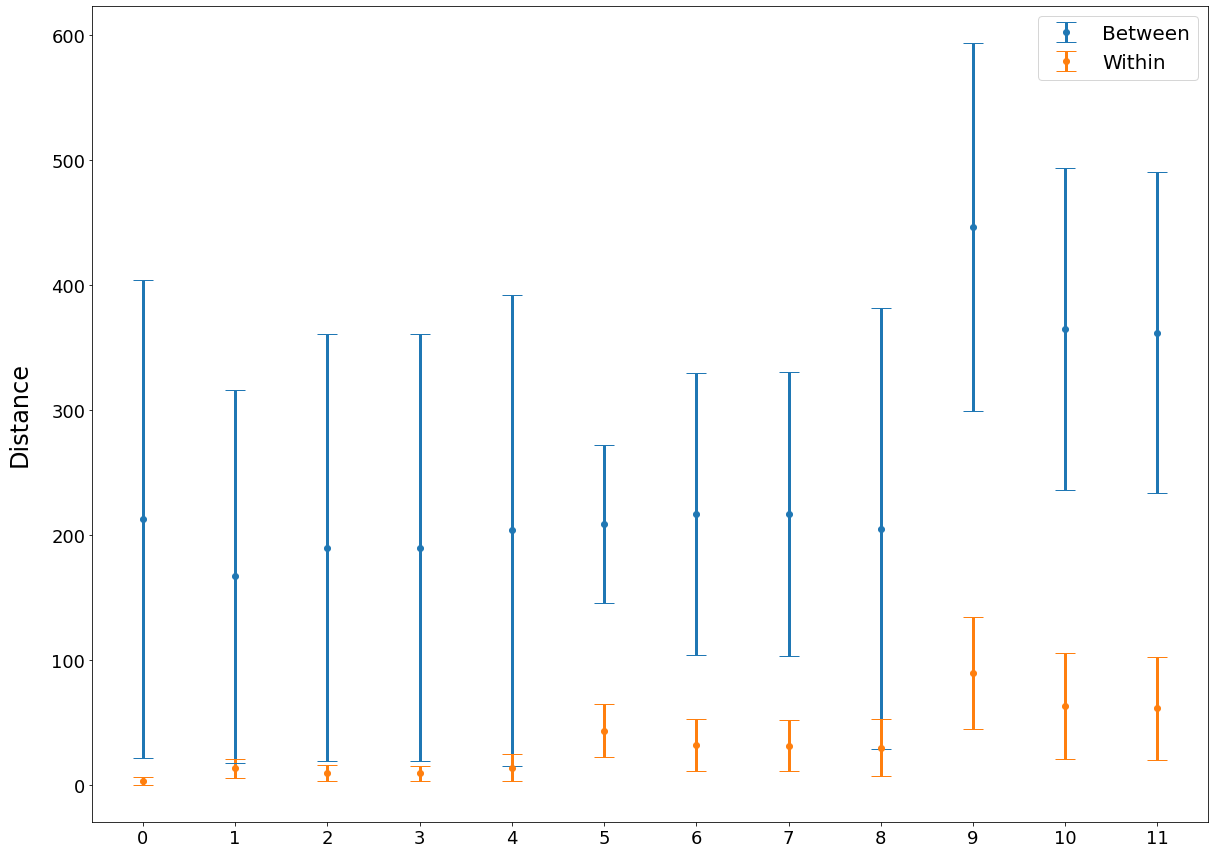

In [48]:
fig, ax = plt.subplots(figsize = (20,15))

w_means = [np.mean(within_cluster_distances[key]) for key in within_cluster_distances.keys()]
w_stds = [np.std(within_cluster_distances[key]) for key in within_cluster_distances.keys()]

b_means = [np.mean(between_cluster_distances[key]) for key in between_cluster_distances.keys()]
b_stds = [np.std(between_cluster_distances[key]) for key in between_cluster_distances.keys()]


ax.errorbar(list(between_cluster_distances.keys()), b_means, b_stds, lw=3, label = "Between",fmt='o', capsize=10)
ax.errorbar(list(within_cluster_distances.keys()), w_means, w_stds, lw=3, label = "Within",fmt='o', capsize=10)
ax.legend(fontsize= 20)

ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis="x", labelsize = 18)
ax.set_ylabel("Distance", fontsize = 24,labelpad = 20)
ax.set_xticks(range(0, len(list(between_cluster_distances.keys()))))
plt.savefig("euclidean+ssim_within_between")

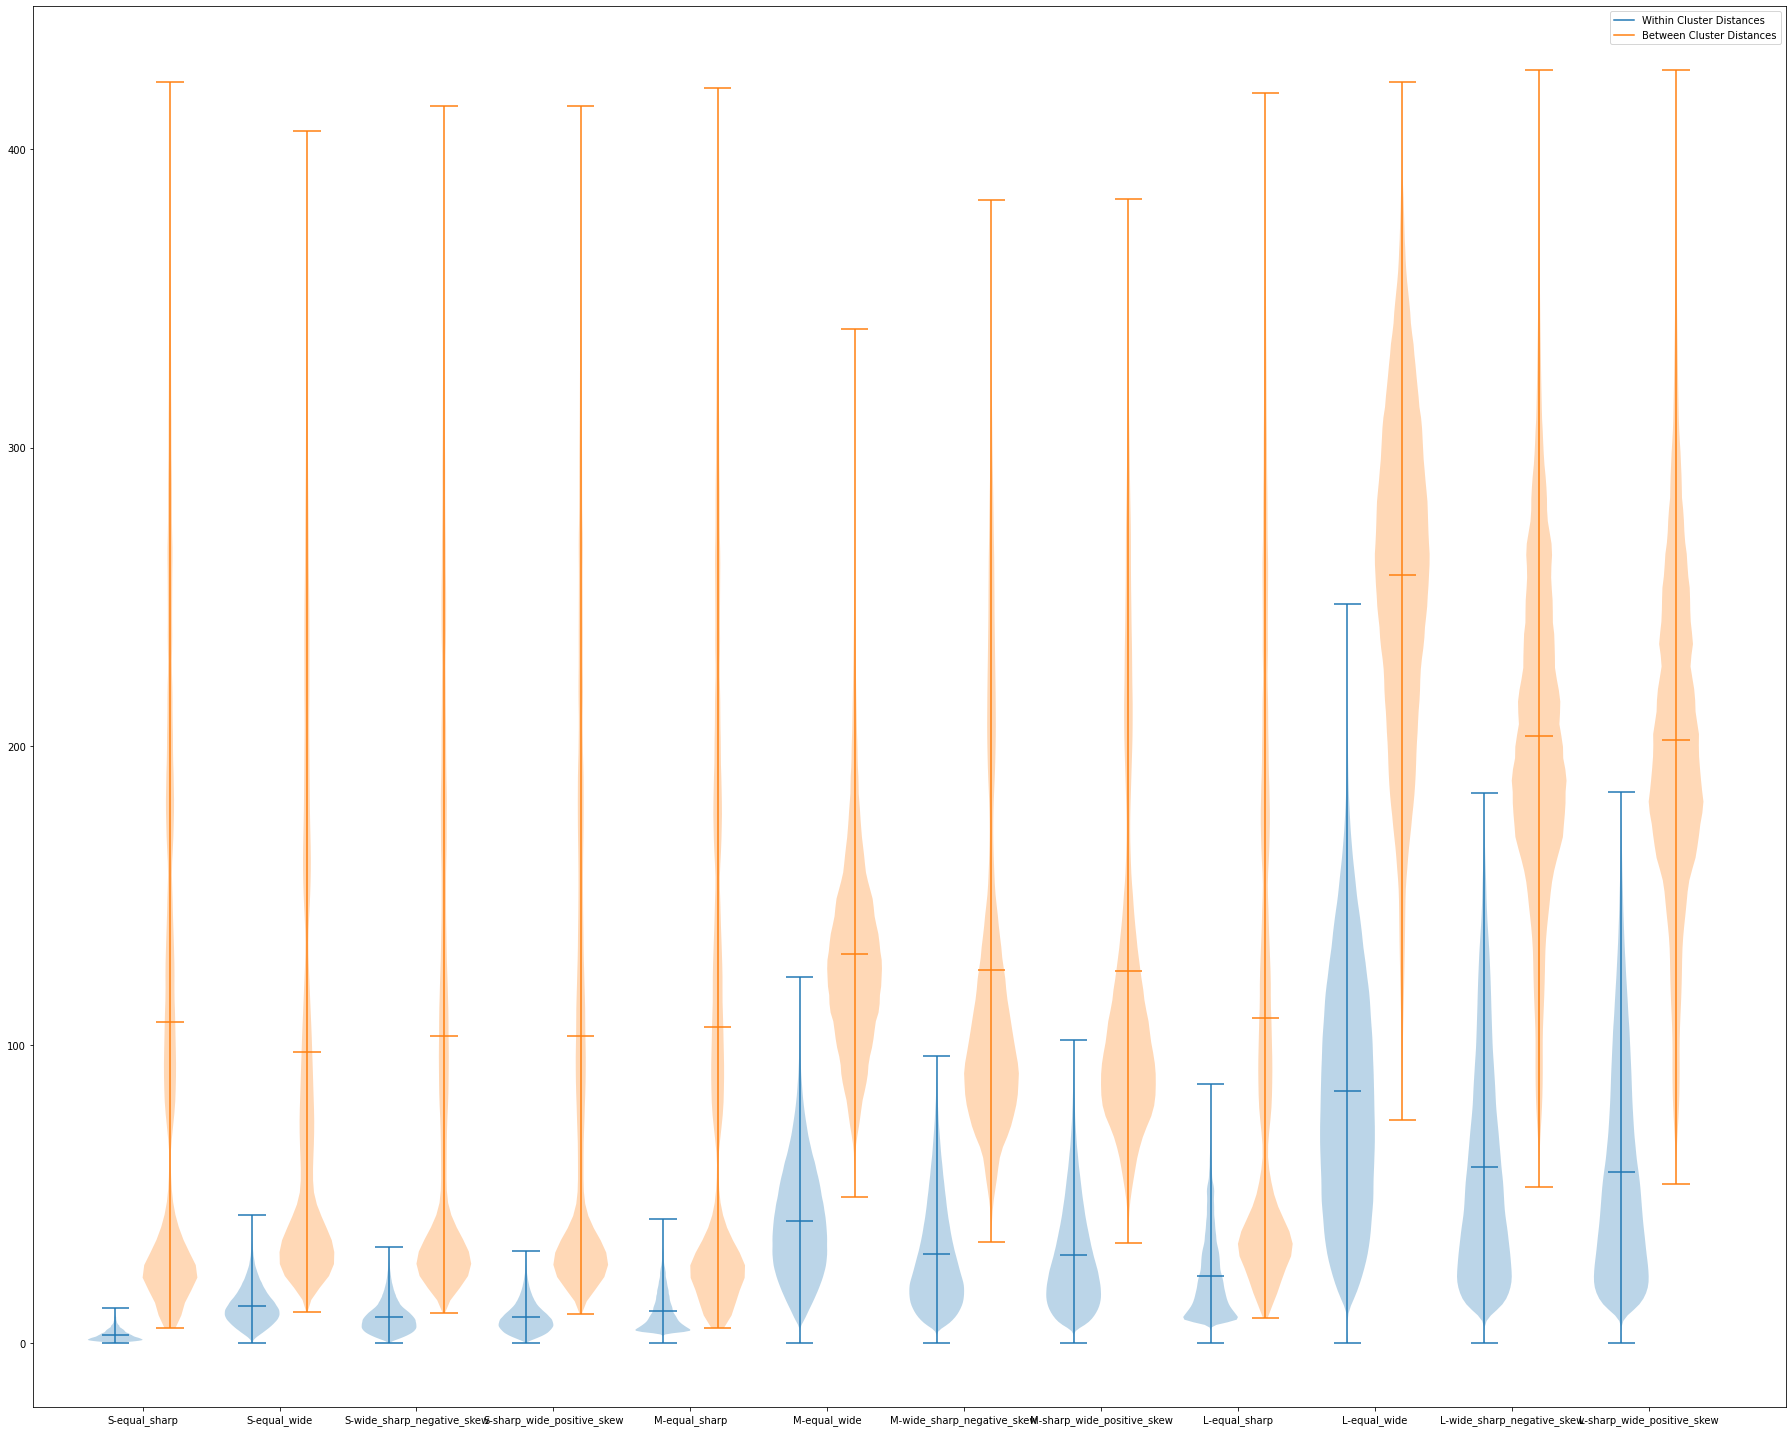

In [28]:
import seaborn as sns
ticks = [key for key in between_cluster_distances]
wd = [within_cluster_distances[key].ravel() for key in within_cluster_distances.keys()]
bd = [between_cluster_distances[key].ravel() for key in between_cluster_distances.keys()]



plt.figure(figsize=(25,20))

bpl = plt.violinplot(wd, positions=np.array(range(len(wd)))*5-1, widths=2,showmeans = True, showextrema = True)

bpr = plt.violinplot(bd, positions=np.array(range(len(bd)))*5+1, widths=2,showmeans = True, showextrema = True)


# draw temporary red and blue lines and use them to create a legend
plt.plot([], color = "C0", label='Within Cluster Distances')
plt.plot([], color = "C1", label='Between Cluster Distances')
plt.legend()

plt.xticks(range(0, len(ticks) * 5, 5), ticks, rotation = 90)
plt.xlim(-4, len(ticks)*5)
plt.tight_layout()

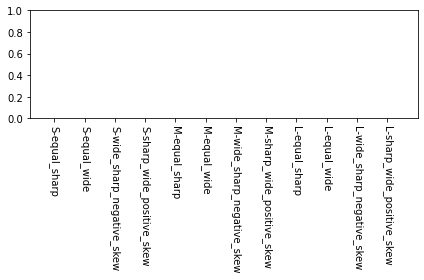

In [30]:
plt.xticks(range(0, len(ticks) * 5, 5), ticks, rotation = -90)
plt.xlim(-4, len(ticks)*5)
plt.tight_layout()

In [7]:
A = construct_knn_graph(dist_matrix,sorted_dist_matrix,k=len(ambig_data)-1, mutual = False, weighting = "distance")

In [8]:
np.mean(A)

115.34996749952657

In [ ]:
import igraph as ig
import cairocffi as cairo
g = ig.Graph.Famous("petersen")
ig.plot(g)

In [ ]:
color_dict = {}
for i in range(10):
    color_dict[i] = "C%d" % i

color_dict[10] = "black"
color_dict[11] = "white"

In [ ]:
g = ig.Graph.Adjacency((A > 0).tolist())

# Add edge weights and node labels.
g.es['weight'] = A[A.nonzero()]
#g.vs['color'] = [color_dict[i] for i in clear_true_labels]  # or a.index/a.columns

In [ ]:
layout = g.layout_lgl()

#ig.plot(g,layout = "layout_lgl")

In [ ]:
ig.plot(g, layout = layout)